In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
#import statsmodels.api as sm

In [2]:
df_receivable = pd.read_csv(r'C:\Users\CLAUDIOCLEMENTE\Bootcamp\Payement predictor\data\WA_Fn-UseC_-Accounts-Receivable.csv')
df_receivable.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [3]:
df_receivable['InvoiceDate']= pd.to_datetime(df_receivable.InvoiceDate)

In [4]:
df_receivable['Late'] = df_receivable['DaysLate'].apply(lambda x: 1 if x >0 else 0)

In [5]:
df_receivable['countlate']=df_receivable.Late.eq(1).groupby(df_receivable.customerID).\
apply(lambda x : x.cumsum().shift().fillna(0)).astype(int)

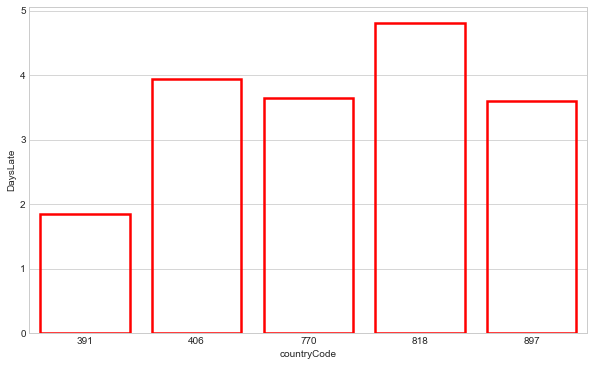

In [6]:
temp = pd.DataFrame(df_receivable.groupby(['countryCode'], axis=0, as_index=False)['DaysLate'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="countryCode", y="DaysLate",data=temp,linewidth=2.5,\
            facecolor=(1, 1, 1, 0),errcolor=".4", edgecolor="red")

In [7]:
customer_late =pd.crosstab(index=df_receivable["customerID"], columns=df_receivable['Late'])
customer_late.sort_values(by=[1], ascending = False)

Late,0,1
customerID,,
0688-XNJRO,2,32
8102-ABPKQ,1,26
8690-EEBEO,5,26
6708-DPYTF,5,25
4460-ZXNDN,3,25
...,...,...
6177-VTITE,21,0
6296-UKEUZ,19,0
6632-CGYHU,20,0


In [8]:
df1 = df_receivable[df_receivable['DaysLate']>0].copy()
df2 = pd.DataFrame(df1.groupby(['customerID'], axis=0, as_index=False)['DaysLate'].count())
df2.columns = (['customerID','repeatCust'])
df3 = pd.merge(df_receivable, df2, how='left', on='customerID')
df3['repeatCust'].fillna(0, inplace=True)

In [9]:
df_receivable = df3

In [10]:
def func_IA (x):
    if x>60: return "b. more than 60"
    else: return "a. less than 60"
df_receivable['InvoiceAmount_bin'] = df_receivable['InvoiceAmount'].apply(func_IA)

In [11]:
df_receivable['Disputed'] = df_receivable['Disputed'].map({'No':0,'Yes':1})
df_receivable['PaperlessBill'] = df_receivable['PaperlessBill'].map({'Paper': 0,'Electronic': 1})

In [12]:
df_receivable['InvoiceQuarter']= pd.to_datetime(df_receivable['InvoiceDate']).dt.quarter

In [13]:
labels = df_receivable['customerID'].astype('category').cat.categories.tolist()

In [14]:
replace_map_comp = {'customerID' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [15]:
df_receivable.replace(replace_map_comp, inplace=True)

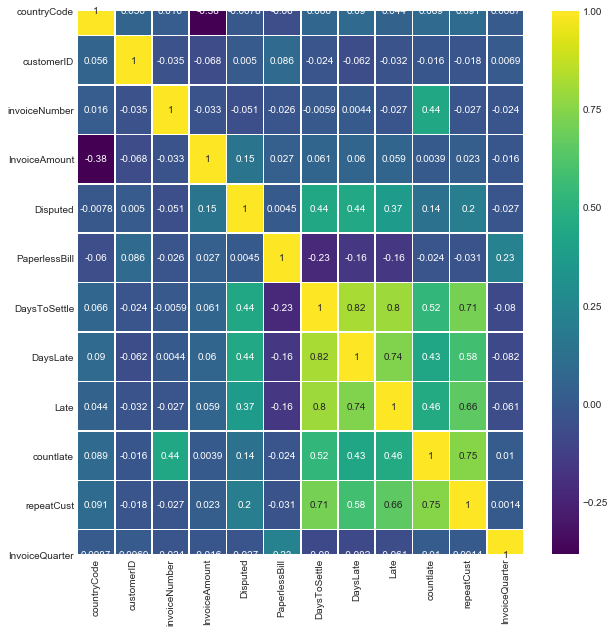

In [16]:
corremat = df_receivable.corr()
plt.figure(figsize=(10,10))
g= sns.heatmap(df_receivable.corr(),annot=True,cmap='viridis',linewidths=.5)

In [17]:
cat_feats = ['InvoiceAmount_bin']
final_data = pd.get_dummies(df_receivable,columns=cat_feats,drop_first=True)

In [18]:
features=['countryCode', 'customerID', 'InvoiceAmount','Disputed', 'PaperlessBill',\
          'repeatCust','Late', 'DaysToSettle','countlate']

In [19]:
X = final_data[features]
y = final_data['DaysLate']

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [21]:
linear=LinearRegression()
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test)

In [22]:
linear_accuracy = round(linear.score(X_train,y_train)*100,2)
print(round(linear_accuracy,2),'%')
print(mean_squared_error(y_test,y_pred))

70.46 %
11.910112740011195


In [23]:
GBR_model = GradientBoostingRegressor(n_estimators=100, max_depth=4)
GBR_model.fit(X_train, y_train)
y_pred2 = GBR_model.predict(X_test)

In [24]:
GBR_model_accuracy = round(GBR_model.score(X_train,y_train)*100,2)
print(round(GBR_model_accuracy,2),'%')
print(mean_squared_error(y_test,y_pred2))

100.0 %
0.005253828272922504


In [25]:
random_model = RandomForestRegressor(n_estimators=1000)
random_model.fit(X_train, y_train)
y_pred3 = random_model.predict(X_test)

In [26]:
#Checking the accuracy
random_model_accuracy = round(random_model.score(X_train,y_train)*100,2)
print(round(random_model_accuracy,2),'%')
print(mean_squared_error(y_test,y_pred3))

99.98 %
0.0008191620745542929


In [ ]:
# add grid search 

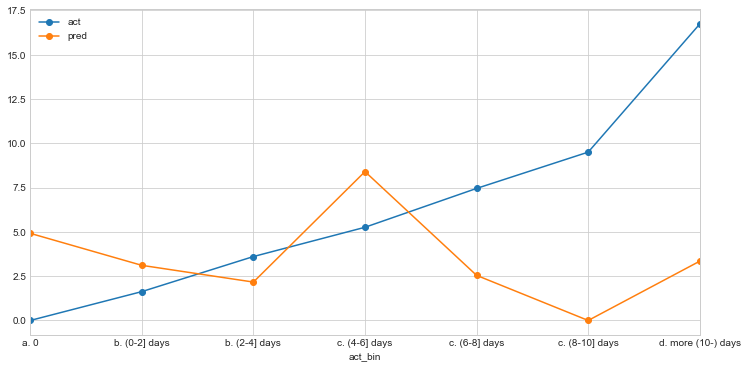

In [27]:
y = pd.concat([y_test,pd.DataFrame(y_pred2)],axis=1)
y.columns = ('act','pred')

def act_decile (x):
    if x == 0: return "a. 0"
    elif x <= 2: return "b. (0-2] days"
    elif x <= 4: return "b. (2-4] days"
    elif x <= 6: return "c. (4-6] days"
    elif x <= 8: return "c. (6-8] days"
    elif x <= 10: return "c. (8-10] days"
    else: return "d. more (10-) days"
y['act_bin'] = y['act'].apply(act_decile)

temp = pd.DataFrame(y.groupby(['act_bin'], axis=0, as_index=False)['act','pred'].mean())
temp.index = temp['act_bin']
temp.plot(marker='o',figsize=(12,6))